In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [ ]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm

In [ ]:
!nvidia-smi

Wed Jan 22 13:49:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Uploading datasets

In [ ]:
path = '/content/drive/MyDrive/'

train = pd.read_csv(path + 'training_set.csv', index_col=0)
validation = pd.read_csv(path + 'validation_set.csv', index_col=0)
test = pd.read_csv(path + 'test_set.csv', index_col=0)

### Combining data for stratifying

In [ ]:
all_data = pd.concat([train, validation, test])
X, y = all_data.drop(columns=['label']), all_data['label']
X = X.astype(float)

In [ ]:
y = y.fillna("NoAction")

In [ ]:
y.value_counts()

,count
label,
NoAction,18059
doubt_question,1271
yn_question,1247
negative,1240
relative,1194
wh_question,1158
conditional,1137
affirmative,942
emphasis,861


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

In [ ]:
print((X_train == 0).sum().sum())
print((X_valid == 0).sum().sum())
print((X_test == 0).sum().sum())

0
0
0


In [ ]:
print("X_train:", X_train.shape)
print("y_train:", len(y_train))

print("X_test:", X_test.shape)
print("y_test:", len(y_test))

print("X_valid", X_valid.shape)
print("y_valid", len(y_valid))

X_train: (22348, 300)
y_train: 22348
X_test: (2794, 300)
y_test: 2794
X_valid (2794, 300)
y_valid 2794


### PCA – Checking linearity


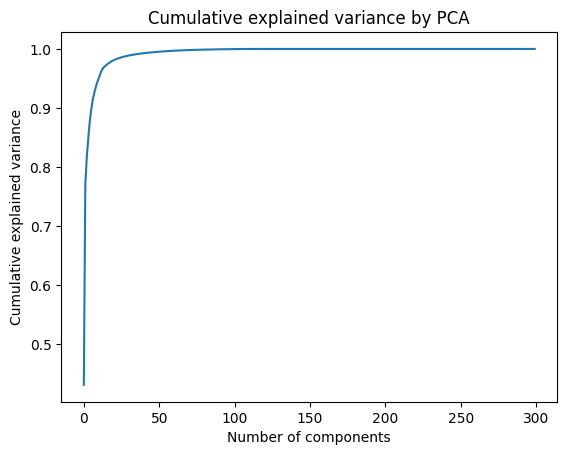

In [ ]:
pca = PCA()
pca.fit(X)

explained_variance = pca.explained_variance_ratio_

plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance by PCA')
plt.show()

### Reducing dimensionality decreased the accuracy of the model, so I left it as it is

## Hyperparameter tuning using Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)
y_test_encoded = le.transform(y_test)

In [ ]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    gamma = trial.suggest_float('gamma', 0.0, 5.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 100)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 5.0)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    seed = 42

    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        seed=seed,
        n_jobs=-1,
        early_stopping_rounds=10
    )

    evaluation = [(X_valid, y_valid_encoded)]
    clf.fit(X_train, y_train_encoded, eval_set=evaluation)

    preds = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid_encoded, preds)
    return accuracy

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=20)

[I 2025-01-22 14:03:34,369] A new study created in memory with name: no-name-5285b45e-c008-4c31-a3f0-20573b876760


[0]	validation_0-mlogloss:1.36868
[1]	validation_0-mlogloss:1.06511
[2]	validation_0-mlogloss:0.86786
[3]	validation_0-mlogloss:0.73313
[4]	validation_0-mlogloss:0.63158
[5]	validation_0-mlogloss:0.55715
[6]	validation_0-mlogloss:0.50072
[7]	validation_0-mlogloss:0.45563
[8]	validation_0-mlogloss:0.41864
[9]	validation_0-mlogloss:0.39032
[10]	validation_0-mlogloss:0.36776
[11]	validation_0-mlogloss:0.35021
[12]	validation_0-mlogloss:0.33552
[13]	validation_0-mlogloss:0.32349
[14]	validation_0-mlogloss:0.31402
[15]	validation_0-mlogloss:0.30730
[16]	validation_0-mlogloss:0.30155
[17]	validation_0-mlogloss:0.29723
[18]	validation_0-mlogloss:0.29429
[19]	validation_0-mlogloss:0.29021
[20]	validation_0-mlogloss:0.28810
[21]	validation_0-mlogloss:0.28666
[22]	validation_0-mlogloss:0.28548
[23]	validation_0-mlogloss:0.28501
[24]	validation_0-mlogloss:0.28450
[25]	validation_0-mlogloss:0.28418
[26]	validation_0-mlogloss:0.28413
[27]	validation_0-mlogloss:0.28356
[28]	validation_0-mlogloss:0.2

[I 2025-01-22 14:03:53,018] Trial 0 finished with value: 0.9069434502505369 and parameters: {'n_estimators': 200, 'max_depth': 12, 'gamma': 2.3014044516275263, 'reg_alpha': 0.9181760754738644, 'reg_lambda': 1.767851498065101, 'min_child_weight': 4, 'colsample_bytree': 0.8416417945516014}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.49680
[1]	validation_0-mlogloss:1.22186
[2]	validation_0-mlogloss:1.03672
[3]	validation_0-mlogloss:0.90781
[4]	validation_0-mlogloss:0.81792
[5]	validation_0-mlogloss:0.74421
[6]	validation_0-mlogloss:0.68605
[7]	validation_0-mlogloss:0.64007
[8]	validation_0-mlogloss:0.60313
[9]	validation_0-mlogloss:0.57412
[10]	validation_0-mlogloss:0.55051
[11]	validation_0-mlogloss:0.53097
[12]	validation_0-mlogloss:0.51448
[13]	validation_0-mlogloss:0.50320
[14]	validation_0-mlogloss:0.49098
[15]	validation_0-mlogloss:0.48175
[16]	validation_0-mlogloss:0.47603
[17]	validation_0-mlogloss:0.47147
[18]	validation_0-mlogloss:0.46737
[19]	validation_0-mlogloss:0.46355
[20]	validation_0-mlogloss:0.46118
[21]	validation_0-mlogloss:0.45960
[22]	validation_0-mlogloss:0.45806
[23]	validation_0-mlogloss:0.45624
[24]	validation_0-mlogloss:0.45564
[25]	validation_0-mlogloss:0.45563
[26]	validation_0-mlogloss:0.45563
[27]	validation_0-mlogloss:0.45563
[28]	validation_0-mlogloss:0.4

[I 2025-01-22 14:04:07,102] Trial 1 finished with value: 0.8536148890479599 and parameters: {'n_estimators': 450, 'max_depth': 9, 'gamma': 3.7280931172259457, 'reg_alpha': 26.655645015427964, 'reg_lambda': 2.8510958036758933, 'min_child_weight': 3, 'colsample_bytree': 0.735762392801091}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.58731
[1]	validation_0-mlogloss:1.32197
[2]	validation_0-mlogloss:1.15689
[3]	validation_0-mlogloss:1.04174
[4]	validation_0-mlogloss:0.94342
[5]	validation_0-mlogloss:0.86617
[6]	validation_0-mlogloss:0.80995
[7]	validation_0-mlogloss:0.75985
[8]	validation_0-mlogloss:0.72049
[9]	validation_0-mlogloss:0.69055
[10]	validation_0-mlogloss:0.66791
[11]	validation_0-mlogloss:0.64608
[12]	validation_0-mlogloss:0.62740
[13]	validation_0-mlogloss:0.61175
[14]	validation_0-mlogloss:0.59953
[15]	validation_0-mlogloss:0.58784
[16]	validation_0-mlogloss:0.57749
[17]	validation_0-mlogloss:0.56993
[18]	validation_0-mlogloss:0.56244
[19]	validation_0-mlogloss:0.55738
[20]	validation_0-mlogloss:0.55317
[21]	validation_0-mlogloss:0.55020
[22]	validation_0-mlogloss:0.54667
[23]	validation_0-mlogloss:0.54499
[24]	validation_0-mlogloss:0.54231
[25]	validation_0-mlogloss:0.54084
[26]	validation_0-mlogloss:0.53994
[27]	validation_0-mlogloss:0.53815
[28]	validation_0-mlogloss:0.5

[I 2025-01-22 14:04:33,574] Trial 2 finished with value: 0.8410880458124552 and parameters: {'n_estimators': 300, 'max_depth': 14, 'gamma': 0.14971200461978418, 'reg_alpha': 84.0240201241492, 'reg_lambda': 3.4648073178911876, 'min_child_weight': 4, 'colsample_bytree': 0.9121933918838918}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.48700
[1]	validation_0-mlogloss:1.21081
[2]	validation_0-mlogloss:1.03041
[3]	validation_0-mlogloss:0.90370
[4]	validation_0-mlogloss:0.81354
[5]	validation_0-mlogloss:0.74322
[6]	validation_0-mlogloss:0.68445
[7]	validation_0-mlogloss:0.63825
[8]	validation_0-mlogloss:0.60196
[9]	validation_0-mlogloss:0.57283
[10]	validation_0-mlogloss:0.55165
[11]	validation_0-mlogloss:0.53469
[12]	validation_0-mlogloss:0.51821
[13]	validation_0-mlogloss:0.50375
[14]	validation_0-mlogloss:0.49390
[15]	validation_0-mlogloss:0.48528
[16]	validation_0-mlogloss:0.47801
[17]	validation_0-mlogloss:0.47385
[18]	validation_0-mlogloss:0.46994
[19]	validation_0-mlogloss:0.46746
[20]	validation_0-mlogloss:0.46598
[21]	validation_0-mlogloss:0.46561
[22]	validation_0-mlogloss:0.46508
[23]	validation_0-mlogloss:0.46506
[24]	validation_0-mlogloss:0.46505
[25]	validation_0-mlogloss:0.46504
[26]	validation_0-mlogloss:0.46504
[27]	validation_0-mlogloss:0.46504
[28]	validation_0-mlogloss:0.4

[I 2025-01-22 14:04:54,698] Trial 3 finished with value: 0.851109520400859 and parameters: {'n_estimators': 250, 'max_depth': 8, 'gamma': 4.911123447067337, 'reg_alpha': 24.674421855292305, 'reg_lambda': 3.5488957165477446, 'min_child_weight': 0, 'colsample_bytree': 0.9174597214169438}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.58578
[1]	validation_0-mlogloss:1.31258
[2]	validation_0-mlogloss:1.15104
[3]	validation_0-mlogloss:1.03016
[4]	validation_0-mlogloss:0.94245
[5]	validation_0-mlogloss:0.86780
[6]	validation_0-mlogloss:0.81258
[7]	validation_0-mlogloss:0.76413
[8]	validation_0-mlogloss:0.72608
[9]	validation_0-mlogloss:0.69561
[10]	validation_0-mlogloss:0.67560
[11]	validation_0-mlogloss:0.65692
[12]	validation_0-mlogloss:0.63858
[13]	validation_0-mlogloss:0.62368
[14]	validation_0-mlogloss:0.61346
[15]	validation_0-mlogloss:0.60758
[16]	validation_0-mlogloss:0.60049
[17]	validation_0-mlogloss:0.59635
[18]	validation_0-mlogloss:0.59418
[19]	validation_0-mlogloss:0.59029
[20]	validation_0-mlogloss:0.58855
[21]	validation_0-mlogloss:0.58664
[22]	validation_0-mlogloss:0.58526
[23]	validation_0-mlogloss:0.58320
[24]	validation_0-mlogloss:0.58120
[25]	validation_0-mlogloss:0.58003
[26]	validation_0-mlogloss:0.57920
[27]	validation_0-mlogloss:0.57746
[28]	validation_0-mlogloss:0.5

[I 2025-01-22 14:05:10,055] Trial 4 finished with value: 0.8256979241231209 and parameters: {'n_estimators': 50, 'max_depth': 10, 'gamma': 2.8379658455242236, 'reg_alpha': 77.17595803529281, 'reg_lambda': 2.4148004480955483, 'min_child_weight': 5, 'colsample_bytree': 0.7518079058696256}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.56937
[1]	validation_0-mlogloss:1.29893
[2]	validation_0-mlogloss:1.12998
[3]	validation_0-mlogloss:1.01533
[4]	validation_0-mlogloss:0.92508
[5]	validation_0-mlogloss:0.84861
[6]	validation_0-mlogloss:0.79123
[7]	validation_0-mlogloss:0.74580
[8]	validation_0-mlogloss:0.71038
[9]	validation_0-mlogloss:0.68225
[10]	validation_0-mlogloss:0.65959
[11]	validation_0-mlogloss:0.63752
[12]	validation_0-mlogloss:0.62056
[13]	validation_0-mlogloss:0.60875
[14]	validation_0-mlogloss:0.59611
[15]	validation_0-mlogloss:0.58801
[16]	validation_0-mlogloss:0.57853
[17]	validation_0-mlogloss:0.57455
[18]	validation_0-mlogloss:0.56987
[19]	validation_0-mlogloss:0.56641
[20]	validation_0-mlogloss:0.56433
[21]	validation_0-mlogloss:0.56283
[22]	validation_0-mlogloss:0.56111
[23]	validation_0-mlogloss:0.55996
[24]	validation_0-mlogloss:0.55876
[25]	validation_0-mlogloss:0.55566
[26]	validation_0-mlogloss:0.55447
[27]	validation_0-mlogloss:0.55335
[28]	validation_0-mlogloss:0.5

[I 2025-01-22 14:05:33,600] Trial 5 finished with value: 0.8339298496778812 and parameters: {'n_estimators': 200, 'max_depth': 6, 'gamma': 2.21347835968075, 'reg_alpha': 67.33315424139789, 'reg_lambda': 4.964759827848358, 'min_child_weight': 0, 'colsample_bytree': 0.8020405053303962}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.58898
[1]	validation_0-mlogloss:1.32744
[2]	validation_0-mlogloss:1.16239
[3]	validation_0-mlogloss:1.04871
[4]	validation_0-mlogloss:0.95455
[5]	validation_0-mlogloss:0.88458
[6]	validation_0-mlogloss:0.82271
[7]	validation_0-mlogloss:0.77541
[8]	validation_0-mlogloss:0.73653
[9]	validation_0-mlogloss:0.70754
[10]	validation_0-mlogloss:0.68259
[11]	validation_0-mlogloss:0.66076
[12]	validation_0-mlogloss:0.64276
[13]	validation_0-mlogloss:0.62909
[14]	validation_0-mlogloss:0.61735
[15]	validation_0-mlogloss:0.60685
[16]	validation_0-mlogloss:0.59894
[17]	validation_0-mlogloss:0.58984
[18]	validation_0-mlogloss:0.58348
[19]	validation_0-mlogloss:0.58019
[20]	validation_0-mlogloss:0.57638
[21]	validation_0-mlogloss:0.57342
[22]	validation_0-mlogloss:0.57009
[23]	validation_0-mlogloss:0.56789
[24]	validation_0-mlogloss:0.56451
[25]	validation_0-mlogloss:0.56239
[26]	validation_0-mlogloss:0.56081
[27]	validation_0-mlogloss:0.55938
[28]	validation_0-mlogloss:0.5

[I 2025-01-22 14:05:57,378] Trial 6 finished with value: 0.8389405869720831 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.10493859250201742, 'reg_alpha': 93.87522846657338, 'reg_lambda': 1.6602789474316944, 'min_child_weight': 2, 'colsample_bytree': 0.9527785290884785}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.55036
[1]	validation_0-mlogloss:1.27566
[2]	validation_0-mlogloss:1.10690
[3]	validation_0-mlogloss:0.99035
[4]	validation_0-mlogloss:0.89599
[5]	validation_0-mlogloss:0.82142
[6]	validation_0-mlogloss:0.76642
[7]	validation_0-mlogloss:0.72065
[8]	validation_0-mlogloss:0.68543
[9]	validation_0-mlogloss:0.65594
[10]	validation_0-mlogloss:0.63495
[11]	validation_0-mlogloss:0.61621
[12]	validation_0-mlogloss:0.60104
[13]	validation_0-mlogloss:0.58638
[14]	validation_0-mlogloss:0.57520
[15]	validation_0-mlogloss:0.56645
[16]	validation_0-mlogloss:0.55935
[17]	validation_0-mlogloss:0.55387
[18]	validation_0-mlogloss:0.55036
[19]	validation_0-mlogloss:0.54630
[20]	validation_0-mlogloss:0.54497
[21]	validation_0-mlogloss:0.54400
[22]	validation_0-mlogloss:0.54241
[23]	validation_0-mlogloss:0.54035
[24]	validation_0-mlogloss:0.53742
[25]	validation_0-mlogloss:0.53633
[26]	validation_0-mlogloss:0.53493
[27]	validation_0-mlogloss:0.53335
[28]	validation_0-mlogloss:0.5

[I 2025-01-22 14:06:34,322] Trial 7 finished with value: 0.8403722261989979 and parameters: {'n_estimators': 250, 'max_depth': 12, 'gamma': 2.000344094891977, 'reg_alpha': 65.28349062886392, 'reg_lambda': 0.2404733945771137, 'min_child_weight': 2, 'colsample_bytree': 0.78213253010858}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.58747
[1]	validation_0-mlogloss:1.32398
[2]	validation_0-mlogloss:1.15081
[3]	validation_0-mlogloss:1.03576
[4]	validation_0-mlogloss:0.94516
[5]	validation_0-mlogloss:0.87386
[6]	validation_0-mlogloss:0.81847
[7]	validation_0-mlogloss:0.77353
[8]	validation_0-mlogloss:0.73736
[9]	validation_0-mlogloss:0.71193
[10]	validation_0-mlogloss:0.69150
[11]	validation_0-mlogloss:0.67316
[12]	validation_0-mlogloss:0.65424
[13]	validation_0-mlogloss:0.64043
[14]	validation_0-mlogloss:0.62900
[15]	validation_0-mlogloss:0.62435
[16]	validation_0-mlogloss:0.61932
[17]	validation_0-mlogloss:0.61596
[18]	validation_0-mlogloss:0.61193
[19]	validation_0-mlogloss:0.60784
[20]	validation_0-mlogloss:0.60629
[21]	validation_0-mlogloss:0.60452
[22]	validation_0-mlogloss:0.60214
[23]	validation_0-mlogloss:0.60073
[24]	validation_0-mlogloss:0.59936
[25]	validation_0-mlogloss:0.59675
[26]	validation_0-mlogloss:0.59561
[27]	validation_0-mlogloss:0.59460
[28]	validation_0-mlogloss:0.5

[I 2025-01-22 14:06:58,056] Trial 8 finished with value: 0.8224767358625626 and parameters: {'n_estimators': 150, 'max_depth': 7, 'gamma': 3.3369469361656363, 'reg_alpha': 82.73304466108286, 'reg_lambda': 3.5533897779803296, 'min_child_weight': 0, 'colsample_bytree': 0.9607877164832559}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.59511
[1]	validation_0-mlogloss:1.34517
[2]	validation_0-mlogloss:1.18514
[3]	validation_0-mlogloss:1.06750
[4]	validation_0-mlogloss:0.98020
[5]	validation_0-mlogloss:0.91300
[6]	validation_0-mlogloss:0.86017
[7]	validation_0-mlogloss:0.81935
[8]	validation_0-mlogloss:0.78246
[9]	validation_0-mlogloss:0.75228
[10]	validation_0-mlogloss:0.72803
[11]	validation_0-mlogloss:0.70676
[12]	validation_0-mlogloss:0.69046
[13]	validation_0-mlogloss:0.67340
[14]	validation_0-mlogloss:0.65891
[15]	validation_0-mlogloss:0.64651
[16]	validation_0-mlogloss:0.63631
[17]	validation_0-mlogloss:0.62653
[18]	validation_0-mlogloss:0.62263
[19]	validation_0-mlogloss:0.61678
[20]	validation_0-mlogloss:0.61378
[21]	validation_0-mlogloss:0.61112
[22]	validation_0-mlogloss:0.60925
[23]	validation_0-mlogloss:0.60769
[24]	validation_0-mlogloss:0.60649
[25]	validation_0-mlogloss:0.60556
[26]	validation_0-mlogloss:0.60405
[27]	validation_0-mlogloss:0.60208
[28]	validation_0-mlogloss:0.6

[I 2025-01-22 14:07:20,494] Trial 9 finished with value: 0.809949892627058 and parameters: {'n_estimators': 100, 'max_depth': 3, 'gamma': 3.4817070258941145, 'reg_alpha': 57.33396447711564, 'reg_lambda': 4.304607351763771, 'min_child_weight': 5, 'colsample_bytree': 0.924673328340871}. Best is trial 0 with value: 0.9069434502505369.


[0]	validation_0-mlogloss:1.38589
[1]	validation_0-mlogloss:1.08947
[2]	validation_0-mlogloss:0.89977
[3]	validation_0-mlogloss:0.76572
[4]	validation_0-mlogloss:0.66747
[5]	validation_0-mlogloss:0.59319
[6]	validation_0-mlogloss:0.53507
[7]	validation_0-mlogloss:0.48791
[8]	validation_0-mlogloss:0.45042
[9]	validation_0-mlogloss:0.42032
[10]	validation_0-mlogloss:0.39646
[11]	validation_0-mlogloss:0.37681
[12]	validation_0-mlogloss:0.36039
[13]	validation_0-mlogloss:0.34686
[14]	validation_0-mlogloss:0.33527
[15]	validation_0-mlogloss:0.32482
[16]	validation_0-mlogloss:0.31556
[17]	validation_0-mlogloss:0.30682
[18]	validation_0-mlogloss:0.30018
[19]	validation_0-mlogloss:0.29502
[20]	validation_0-mlogloss:0.28973
[21]	validation_0-mlogloss:0.28535
[22]	validation_0-mlogloss:0.28238
[23]	validation_0-mlogloss:0.28022
[24]	validation_0-mlogloss:0.27757
[25]	validation_0-mlogloss:0.27602
[26]	validation_0-mlogloss:0.27528
[27]	validation_0-mlogloss:0.27452
[28]	validation_0-mlogloss:0.2

[I 2025-01-22 14:07:39,502] Trial 10 finished with value: 0.9087329992841804 and parameters: {'n_estimators': 400, 'max_depth': 15, 'gamma': 1.0075388871204254, 'reg_alpha': 4.0870577304256654, 'reg_lambda': 1.0646031633170456, 'min_child_weight': 8, 'colsample_bytree': 0.5353721216383476}. Best is trial 10 with value: 0.9087329992841804.


[0]	validation_0-mlogloss:1.36779
[1]	validation_0-mlogloss:1.06152
[2]	validation_0-mlogloss:0.86956
[3]	validation_0-mlogloss:0.73202
[4]	validation_0-mlogloss:0.62441
[5]	validation_0-mlogloss:0.54755
[6]	validation_0-mlogloss:0.48932
[7]	validation_0-mlogloss:0.44355
[8]	validation_0-mlogloss:0.40617
[9]	validation_0-mlogloss:0.37711
[10]	validation_0-mlogloss:0.35221
[11]	validation_0-mlogloss:0.33354
[12]	validation_0-mlogloss:0.31978
[13]	validation_0-mlogloss:0.30669
[14]	validation_0-mlogloss:0.29617
[15]	validation_0-mlogloss:0.28670
[16]	validation_0-mlogloss:0.27913
[17]	validation_0-mlogloss:0.27316
[18]	validation_0-mlogloss:0.26670
[19]	validation_0-mlogloss:0.26204
[20]	validation_0-mlogloss:0.25907
[21]	validation_0-mlogloss:0.25583
[22]	validation_0-mlogloss:0.25265
[23]	validation_0-mlogloss:0.25026
[24]	validation_0-mlogloss:0.24917
[25]	validation_0-mlogloss:0.24868
[26]	validation_0-mlogloss:0.24811
[27]	validation_0-mlogloss:0.24765
[28]	validation_0-mlogloss:0.2

[I 2025-01-22 14:08:01,431] Trial 11 finished with value: 0.9209019327129563 and parameters: {'n_estimators': 400, 'max_depth': 15, 'gamma': 1.2047458356292782, 'reg_alpha': 0.9427123898136772, 'reg_lambda': 0.9616971728476487, 'min_child_weight': 9, 'colsample_bytree': 0.5035213563330843}. Best is trial 11 with value: 0.9209019327129563.


[0]	validation_0-mlogloss:1.35786
[1]	validation_0-mlogloss:1.05168
[2]	validation_0-mlogloss:0.86151
[3]	validation_0-mlogloss:0.72429
[4]	validation_0-mlogloss:0.62010
[5]	validation_0-mlogloss:0.54476
[6]	validation_0-mlogloss:0.48773
[7]	validation_0-mlogloss:0.44160
[8]	validation_0-mlogloss:0.40498
[9]	validation_0-mlogloss:0.37613
[10]	validation_0-mlogloss:0.35202
[11]	validation_0-mlogloss:0.33376
[12]	validation_0-mlogloss:0.31807
[13]	validation_0-mlogloss:0.30475
[14]	validation_0-mlogloss:0.29444
[15]	validation_0-mlogloss:0.28561
[16]	validation_0-mlogloss:0.27854
[17]	validation_0-mlogloss:0.27282
[18]	validation_0-mlogloss:0.26849
[19]	validation_0-mlogloss:0.26406
[20]	validation_0-mlogloss:0.26095
[21]	validation_0-mlogloss:0.25824
[22]	validation_0-mlogloss:0.25674
[23]	validation_0-mlogloss:0.25479
[24]	validation_0-mlogloss:0.25348
[25]	validation_0-mlogloss:0.25248
[26]	validation_0-mlogloss:0.25222
[27]	validation_0-mlogloss:0.25169
[28]	validation_0-mlogloss:0.2

[I 2025-01-22 14:08:20,714] Trial 12 finished with value: 0.9212598425196851 and parameters: {'n_estimators': 450, 'max_depth': 15, 'gamma': 1.1768643404897319, 'reg_alpha': 1.1184444074103905, 'reg_lambda': 0.3869943114821779, 'min_child_weight': 9, 'colsample_bytree': 0.5152130659929851}. Best is trial 12 with value: 0.9212598425196851.


[0]	validation_0-mlogloss:1.47718
[1]	validation_0-mlogloss:1.19454
[2]	validation_0-mlogloss:1.00909
[3]	validation_0-mlogloss:0.87975
[4]	validation_0-mlogloss:0.78828
[5]	validation_0-mlogloss:0.71888
[6]	validation_0-mlogloss:0.65928
[7]	validation_0-mlogloss:0.61411
[8]	validation_0-mlogloss:0.57725
[9]	validation_0-mlogloss:0.54721
[10]	validation_0-mlogloss:0.52302
[11]	validation_0-mlogloss:0.50138
[12]	validation_0-mlogloss:0.48464
[13]	validation_0-mlogloss:0.46994
[14]	validation_0-mlogloss:0.45623
[15]	validation_0-mlogloss:0.44568
[16]	validation_0-mlogloss:0.43657
[17]	validation_0-mlogloss:0.42801
[18]	validation_0-mlogloss:0.42068
[19]	validation_0-mlogloss:0.41463
[20]	validation_0-mlogloss:0.40778
[21]	validation_0-mlogloss:0.40380
[22]	validation_0-mlogloss:0.40117
[23]	validation_0-mlogloss:0.40004
[24]	validation_0-mlogloss:0.39866
[25]	validation_0-mlogloss:0.39698
[26]	validation_0-mlogloss:0.39645
[27]	validation_0-mlogloss:0.39532
[28]	validation_0-mlogloss:0.3

[I 2025-01-22 14:08:39,658] Trial 13 finished with value: 0.8740157480314961 and parameters: {'n_estimators': 500, 'max_depth': 13, 'gamma': 1.1134596401400185, 'reg_alpha': 23.068596771254725, 'reg_lambda': 0.005608718181867811, 'min_child_weight': 10, 'colsample_bytree': 0.5326433134351297}. Best is trial 12 with value: 0.9212598425196851.


[0]	validation_0-mlogloss:1.52572
[1]	validation_0-mlogloss:1.25216
[2]	validation_0-mlogloss:1.07511
[3]	validation_0-mlogloss:0.95630
[4]	validation_0-mlogloss:0.85988
[5]	validation_0-mlogloss:0.79084
[6]	validation_0-mlogloss:0.72716
[7]	validation_0-mlogloss:0.67973
[8]	validation_0-mlogloss:0.64055
[9]	validation_0-mlogloss:0.60897
[10]	validation_0-mlogloss:0.58758
[11]	validation_0-mlogloss:0.56756
[12]	validation_0-mlogloss:0.54961
[13]	validation_0-mlogloss:0.53519
[14]	validation_0-mlogloss:0.52185
[15]	validation_0-mlogloss:0.51112
[16]	validation_0-mlogloss:0.50119
[17]	validation_0-mlogloss:0.49307
[18]	validation_0-mlogloss:0.48689
[19]	validation_0-mlogloss:0.48162
[20]	validation_0-mlogloss:0.47866
[21]	validation_0-mlogloss:0.47541
[22]	validation_0-mlogloss:0.47226
[23]	validation_0-mlogloss:0.47098
[24]	validation_0-mlogloss:0.46883
[25]	validation_0-mlogloss:0.46799
[26]	validation_0-mlogloss:0.46718
[27]	validation_0-mlogloss:0.46613
[28]	validation_0-mlogloss:0.4

[I 2025-01-22 14:08:57,215] Trial 14 finished with value: 0.8575518969219756 and parameters: {'n_estimators': 350, 'max_depth': 15, 'gamma': 1.3765750574905211, 'reg_alpha': 40.606718709103745, 'reg_lambda': 0.8345542540873332, 'min_child_weight': 8, 'colsample_bytree': 0.6301135153339231}. Best is trial 12 with value: 0.9212598425196851.


[0]	validation_0-mlogloss:1.44760
[1]	validation_0-mlogloss:1.15977
[2]	validation_0-mlogloss:0.97586
[3]	validation_0-mlogloss:0.85035
[4]	validation_0-mlogloss:0.75293
[5]	validation_0-mlogloss:0.68009
[6]	validation_0-mlogloss:0.62191
[7]	validation_0-mlogloss:0.57596
[8]	validation_0-mlogloss:0.53831
[9]	validation_0-mlogloss:0.50551
[10]	validation_0-mlogloss:0.48038
[11]	validation_0-mlogloss:0.46148
[12]	validation_0-mlogloss:0.44502
[13]	validation_0-mlogloss:0.43099
[14]	validation_0-mlogloss:0.41862
[15]	validation_0-mlogloss:0.40771
[16]	validation_0-mlogloss:0.39753
[17]	validation_0-mlogloss:0.38874
[18]	validation_0-mlogloss:0.38179
[19]	validation_0-mlogloss:0.37397
[20]	validation_0-mlogloss:0.36825
[21]	validation_0-mlogloss:0.36360
[22]	validation_0-mlogloss:0.35900
[23]	validation_0-mlogloss:0.35443
[24]	validation_0-mlogloss:0.35060
[25]	validation_0-mlogloss:0.34681
[26]	validation_0-mlogloss:0.34503
[27]	validation_0-mlogloss:0.34418
[28]	validation_0-mlogloss:0.3

[I 2025-01-22 14:09:18,455] Trial 15 finished with value: 0.89226914817466 and parameters: {'n_estimators': 500, 'max_depth': 12, 'gamma': 0.7125186950668405, 'reg_alpha': 14.576414558192274, 'reg_lambda': 0.8028136176699436, 'min_child_weight': 8, 'colsample_bytree': 0.6177785395041403}. Best is trial 12 with value: 0.9212598425196851.


[0]	validation_0-mlogloss:1.54111
[1]	validation_0-mlogloss:1.25880
[2]	validation_0-mlogloss:1.08090
[3]	validation_0-mlogloss:0.95623
[4]	validation_0-mlogloss:0.86362
[5]	validation_0-mlogloss:0.78837
[6]	validation_0-mlogloss:0.73076
[7]	validation_0-mlogloss:0.68440
[8]	validation_0-mlogloss:0.64510
[9]	validation_0-mlogloss:0.61668
[10]	validation_0-mlogloss:0.59212
[11]	validation_0-mlogloss:0.56959
[12]	validation_0-mlogloss:0.55189
[13]	validation_0-mlogloss:0.53722
[14]	validation_0-mlogloss:0.52529
[15]	validation_0-mlogloss:0.51338
[16]	validation_0-mlogloss:0.50342
[17]	validation_0-mlogloss:0.49631
[18]	validation_0-mlogloss:0.49231
[19]	validation_0-mlogloss:0.48835
[20]	validation_0-mlogloss:0.48521
[21]	validation_0-mlogloss:0.48239
[22]	validation_0-mlogloss:0.47976
[23]	validation_0-mlogloss:0.47829
[24]	validation_0-mlogloss:0.47714
[25]	validation_0-mlogloss:0.47534
[26]	validation_0-mlogloss:0.47429
[27]	validation_0-mlogloss:0.47389
[28]	validation_0-mlogloss:0.4

[I 2025-01-22 14:09:41,292] Trial 16 finished with value: 0.8575518969219756 and parameters: {'n_estimators': 400, 'max_depth': 15, 'gamma': 1.5639533397978598, 'reg_alpha': 41.78223610583802, 'reg_lambda': 1.4702436841511002, 'min_child_weight': 10, 'colsample_bytree': 0.5016472914098691}. Best is trial 12 with value: 0.9212598425196851.


[0]	validation_0-mlogloss:1.42872
[1]	validation_0-mlogloss:1.14153
[2]	validation_0-mlogloss:0.95442
[3]	validation_0-mlogloss:0.82400
[4]	validation_0-mlogloss:0.72759
[5]	validation_0-mlogloss:0.65594
[6]	validation_0-mlogloss:0.59926
[7]	validation_0-mlogloss:0.55279
[8]	validation_0-mlogloss:0.51412
[9]	validation_0-mlogloss:0.48535
[10]	validation_0-mlogloss:0.46126
[11]	validation_0-mlogloss:0.44171
[12]	validation_0-mlogloss:0.42346
[13]	validation_0-mlogloss:0.40735
[14]	validation_0-mlogloss:0.39597
[15]	validation_0-mlogloss:0.38458
[16]	validation_0-mlogloss:0.37405
[17]	validation_0-mlogloss:0.36595
[18]	validation_0-mlogloss:0.35881
[19]	validation_0-mlogloss:0.35201
[20]	validation_0-mlogloss:0.34703
[21]	validation_0-mlogloss:0.34207
[22]	validation_0-mlogloss:0.33700
[23]	validation_0-mlogloss:0.33305
[24]	validation_0-mlogloss:0.32877
[25]	validation_0-mlogloss:0.32589
[26]	validation_0-mlogloss:0.32402
[27]	validation_0-mlogloss:0.32259
[28]	validation_0-mlogloss:0.3

[I 2025-01-22 14:10:05,064] Trial 17 finished with value: 0.8979957050823193 and parameters: {'n_estimators': 400, 'max_depth': 13, 'gamma': 0.6042003342158421, 'reg_alpha': 11.96938222988078, 'reg_lambda': 0.4841334495860141, 'min_child_weight': 7, 'colsample_bytree': 0.6248715495861468}. Best is trial 12 with value: 0.9212598425196851.


[0]	validation_0-mlogloss:1.55757
[1]	validation_0-mlogloss:1.29185
[2]	validation_0-mlogloss:1.12604
[3]	validation_0-mlogloss:1.00649
[4]	validation_0-mlogloss:0.91384
[5]	validation_0-mlogloss:0.84190
[6]	validation_0-mlogloss:0.78319
[7]	validation_0-mlogloss:0.73781
[8]	validation_0-mlogloss:0.70067
[9]	validation_0-mlogloss:0.66794
[10]	validation_0-mlogloss:0.64247
[11]	validation_0-mlogloss:0.62223
[12]	validation_0-mlogloss:0.60051
[13]	validation_0-mlogloss:0.58586
[14]	validation_0-mlogloss:0.57353
[15]	validation_0-mlogloss:0.55971
[16]	validation_0-mlogloss:0.54779
[17]	validation_0-mlogloss:0.53945
[18]	validation_0-mlogloss:0.52876
[19]	validation_0-mlogloss:0.52086
[20]	validation_0-mlogloss:0.51553
[21]	validation_0-mlogloss:0.51058
[22]	validation_0-mlogloss:0.50900
[23]	validation_0-mlogloss:0.50709
[24]	validation_0-mlogloss:0.50407
[25]	validation_0-mlogloss:0.50257
[26]	validation_0-mlogloss:0.50098
[27]	validation_0-mlogloss:0.49928
[28]	validation_0-mlogloss:0.4

[I 2025-01-22 14:10:26,352] Trial 18 finished with value: 0.8403722261989979 and parameters: {'n_estimators': 350, 'max_depth': 4, 'gamma': 1.7972644564204765, 'reg_alpha': 36.222270476169655, 'reg_lambda': 2.253979944467495, 'min_child_weight': 7, 'colsample_bytree': 0.6832665019646411}. Best is trial 12 with value: 0.9212598425196851.


[0]	validation_0-mlogloss:1.44453
[1]	validation_0-mlogloss:1.15533
[2]	validation_0-mlogloss:0.96714
[3]	validation_0-mlogloss:0.83902
[4]	validation_0-mlogloss:0.74023
[5]	validation_0-mlogloss:0.66565
[6]	validation_0-mlogloss:0.60790
[7]	validation_0-mlogloss:0.56422
[8]	validation_0-mlogloss:0.52920
[9]	validation_0-mlogloss:0.49994
[10]	validation_0-mlogloss:0.47545
[11]	validation_0-mlogloss:0.45621
[12]	validation_0-mlogloss:0.44092
[13]	validation_0-mlogloss:0.42780
[14]	validation_0-mlogloss:0.41662
[15]	validation_0-mlogloss:0.40666
[16]	validation_0-mlogloss:0.39894
[17]	validation_0-mlogloss:0.39110
[18]	validation_0-mlogloss:0.38602
[19]	validation_0-mlogloss:0.38216
[20]	validation_0-mlogloss:0.38008
[21]	validation_0-mlogloss:0.37884
[22]	validation_0-mlogloss:0.37705
[23]	validation_0-mlogloss:0.37681
[24]	validation_0-mlogloss:0.37629
[25]	validation_0-mlogloss:0.37573
[26]	validation_0-mlogloss:0.37575
[27]	validation_0-mlogloss:0.37576
[28]	validation_0-mlogloss:0.3

[I 2025-01-22 14:10:39,874] Trial 19 finished with value: 0.8801002147458841 and parameters: {'n_estimators': 450, 'max_depth': 10, 'gamma': 2.9866616959906493, 'reg_alpha': 10.61417456730856, 'reg_lambda': 1.2583636205528568, 'min_child_weight': 9, 'colsample_bytree': 0.5754387549211407}. Best is trial 12 with value: 0.9212598425196851.


In [ ]:
study.best_trial.params

{'n_estimators': 450,
 'max_depth': 15,
 'gamma': 1.1768643404897319,
 'reg_alpha': 1.1184444074103905,
 'reg_lambda': 0.3869943114821779,
 'min_child_weight': 9,
 'colsample_bytree': 0.5152130659929851}

In [ ]:
study.best_trial.value

0.9212598425196851

### Parameters obtained as a result of hyperparameter tuning

In [ ]:
params = {'n_estimators': 450,
 'max_depth': 15,
 'gamma': 1.1768643404897319,
 'reg_alpha': 1.1184444074103905,
 'reg_lambda': 0.3869943114821779,
 'min_child_weight': 9,
 'colsample_bytree': 0.5152130659929851}

### Final model prediction

In [ ]:
best_params = study.best_trial.params

In [ ]:
best_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    min_child_weight=best_params['min_child_weight'],
    colsample_bytree=best_params['colsample_bytree'],
    seed=42,
    n_jobs=-1
)


X_full_train = pd.concat([X_train, X_valid])
y_full_train = np.concatenate([y_train_encoded, y_valid_encoded], axis=0)

best_model.fit(X_full_train, y_full_train)

y_test_pred = best_model.predict(X_test)

accuracy_score(y_test_encoded, y_test_pred)

0.9327129563350036

### Checking the accuracy of the model

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1806
           1       0.92      0.74      0.82        94
           2       0.94      0.89      0.91       114
           3       0.92      0.94      0.93       127
           4       0.92      0.88      0.90        86
           5       0.87      0.78      0.83       124
           6       0.96      0.87      0.92       119
           7       0.92      0.84      0.88        83
           8       0.92      0.95      0.93       116
           9       0.89      0.93      0.91       125

    accuracy                           0.93      2794
   macro avg       0.92      0.88      0.90      2794
weighted avg       0.93      0.93      0.93      2794



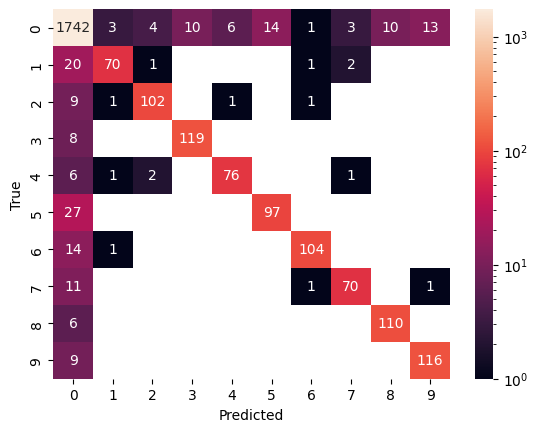

In [ ]:
cm = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", norm=LogNorm())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()